In [1]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
base = Path.cwd().parents[1]
df = pd.read_csv(base / "Data_clean/caract-2005-2023.csv")

df.head()


C:\Users\jeanl\AppData\Local\Temp\ipykernel_10960\3316542733.py:8: DtypeWarning: Columns (10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(base / "Data_clean/caract-2005-2023.csv")


,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,date,weekday
0,200500000001,2005,1,12,19:00,3,2,1,1.0,3.0,11,CD41B,M,50.515,2.944,590,2005-01-12,3
1,200500000002,2005,1,21,16:00,1,2,1,1.0,1.0,51,rue de Lille,M,50.537,2.802,590,2005-01-21,5
2,200500000003,2005,1,21,18:45,3,1,1,2.0,1.0,51,NaN,M,50.546,2.800,590,2005-01-21,5
3,200500000004,2005,1,4,16:15,1,1,1,1.0,5.0,82,NaN,M,50.987,2.408,590,2005-01-04,2
4,200500000005,2005,1,10,19:45,3,1,1,3.0,6.0,478,NaN,M,50.964,2.475,590,2005-01-10,1


In [88]:
df_night = df[(df["hrmn"] > "21:00") | (df["hrmn"] < "06:00")]

In [89]:

df_night = df_night.copy()  
df_night["night"] = df_night["weekday"]

mask_early_morning = df_night["hrmn"] < "06:00"


df_night.loc[mask_early_morning & (df_night["weekday"] != 1), "night"] = df_night["weekday"] - 1
df_night.loc[mask_early_morning & (df_night["weekday"] == 1), "night"] = 7
df_night = df_night.drop_duplicates(subset=['Num_Acc'], keep='first')

print("Exemples d'ajustement pour les heures < 06:00:")
early_morning = df_night[df_night["hrmn"] < "06:00"][["hrmn", "weekday", "night"]].head(10)
print(early_morning)

print(f"\nDistribution des accidents de nuit par jour:")
print(df_night["night"].value_counts().sort_index())

Exemples d'ajustement pour les heures < 06:00:
      hrmn  weekday  night
10   02:30        7      6
27   00:45        7      6
36   00:15        6      5
41   05:00        4      3
69   00:30        6      5
76   03:00        4      3
81   05:00        6      5
84   05:30        7      6
105  02:30        7      6
114  05:30        7      6

Distribution des accidents de nuit par jour:
night
1    17410
2    19468
3    20835
4    24762
5    41201
6    42705
7    19495
Name: count, dtype: int64


In [90]:
df_night.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185876 entries, 7 to 1231683
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Num_Acc  185876 non-null  int64  
 1   an       185876 non-null  int64  
 2   mois     185876 non-null  int64  
 3   jour     185876 non-null  int64  
 4   hrmn     185876 non-null  object 
 5   lum      185876 non-null  int64  
 6   agg      185876 non-null  int64  
 7   int      185876 non-null  int64  
 8   atm      185863 non-null  float64
 9   col      185871 non-null  float64
 10  com      185875 non-null  object 
 11  adr      161032 non-null  object 
 12  gps      73660 non-null   object 
 13  lat      115269 non-null  float64
 14  long     114813 non-null  float64
 15  dep      185876 non-null  object 
 16  date     185876 non-null  object 
 17  weekday  185876 non-null  int64  
 18  night    185876 non-null  int64  
dtypes: float64(4), int64(9), object(6)
memory usage: 32.4+ MB


In [91]:
df_night.Num_Acc.nunique()

185876

## Nombre d'accident chaque soir


       nb_accidents
night              
1             17410
2             19468
3             20835
4             24762
5             41201
6             42705
7             19495


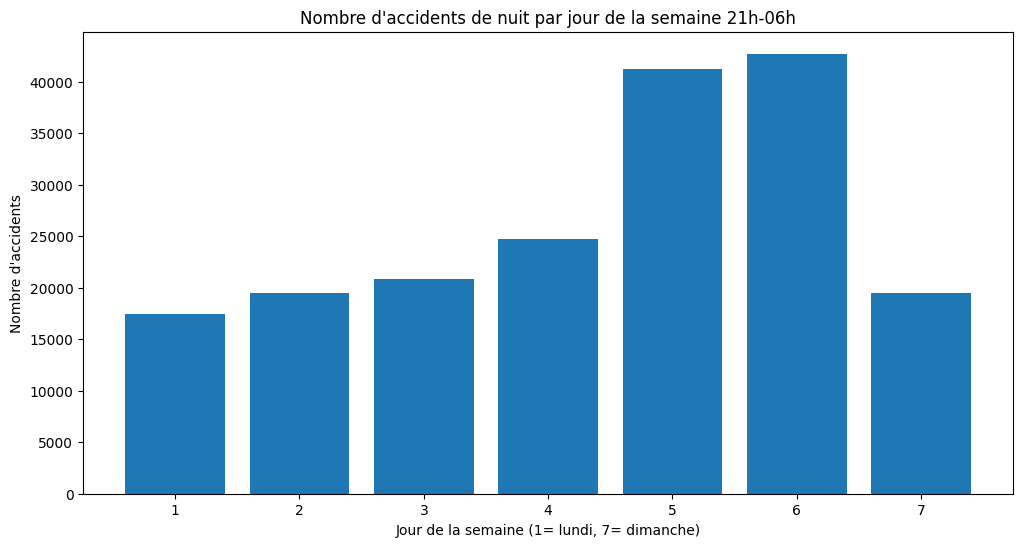

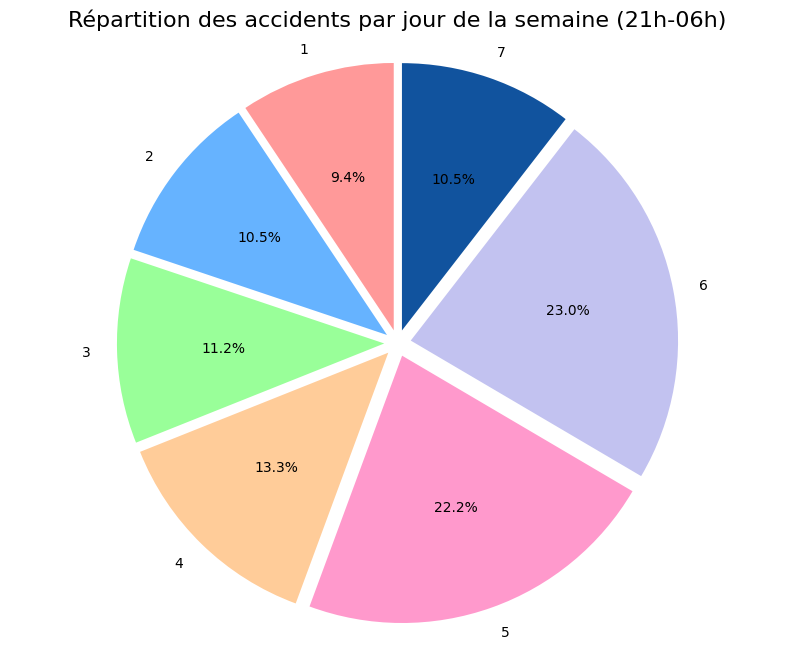

In [132]:
nb_accidents = df_night.groupby("night").Num_Acc.nunique().to_frame(name = "nb_accidents")
print(nb_accidents)
plt.figure(figsize = (12,6))
plt.bar(nb_accidents.index, nb_accidents["nb_accidents"])
plt.xlabel("Jour de la semaine (1= lundi, 7= dimanche)")
plt.ylabel("Nombre d'accidents")
plt.title("Nombre d'accidents de nuit par jour de la semaine 21h-06h")
plt.show()

plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0', "#11539E"]
plt.pie(nb_accidents["nb_accidents"],  # ✅ Les VALEURS ici
        labels=nb_accidents.index,      # ✅ Les LABELS ici
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05))
plt.title('Répartition des accidents par jour de la semaine (21h-06h)', fontsize=16)  # ✅ Titre corrigé aussi
plt.axis('equal')
plt.show()

## Fusion des datasets

In [93]:
base = Path.cwd().parents[1]

df_lieux = pd.read_csv(base / "Data_clean/lieux-2005-2023.csv")
df_vehicules = pd.read_csv(base / "Data_clean/vehicules-2005-2023.csv", index_col=0)
df_usagers = pd.read_csv(base / "Data_clean/usagers-2005-2023.csv",index_col=0)
df_night["Num_Acc"] = df_night["Num_Acc"].fillna(0).astype(int)
df_lieux.head()


C:\Users\jeanl\AppData\Local\Temp\ipykernel_10328\3115654497.py:3: DtypeWarning: Columns (2,6,7,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieux = pd.read_csv(base / "Data_clean/lieux-2005-2023.csv")
C:\Users\jeanl\AppData\Local\Temp\ipykernel_10328\3115654497.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vehicules = pd.read_csv(base / "Data_clean/vehicules-2005-2023.csv", index_col=0)
C:\Users\jeanl\AppData\Local\Temp\ipykernel_10328\3115654497.py:5: DtypeWarning: Columns (9,13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_usagers = pd.read_csv(base / "Data_clean/usagers-2005-2023.csv",index_col=0)


,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1,vma
0,200500000001,3.0,41.0,0.0,B,2.0,2,1.0,430.0,0.0,1.0,1.0,0,63,1.0,0.0,1.0,0.0,NaN
1,200500000002,2.0,41.0,0.0,NaN,0.0,2,0.0,0.0,1.0,1.0,1.0,0,100,1.0,0.0,5.0,0.0,NaN
2,200500000003,2.0,41.0,0.0,NaN,0.0,0,0.0,0.0,1.0,1.0,1.0,0,0,2.0,0.0,5.0,0.0,NaN
3,200500000004,3.0,916.0,0.0,NaN,2.0,2,0.0,0.0,0.0,1.0,1.0,0,0,1.0,0.0,1.0,0.0,NaN
4,200500000005,3.0,110.0,0.0,NaN,2.0,2,24.0,630.0,0.0,1.0,3.0,0,59,2.0,0.0,3.0,0.0,NaN


In [94]:
df_complet = df_night.merge(df_lieux, on="Num_Acc", how="inner")
df_complet = df_complet.drop_duplicates(subset=['Num_Acc'], keep='first')

In [95]:
df_complet = df_complet.merge(df_vehicules, on="Num_Acc", how = "inner")


In [96]:
pd.set_option('display.max_columns', None)  
df_complet

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,date,weekday,night,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1,vma,senc,catv,occutc,obs,obsm,choc,manv,num_veh,id_vehicule,motor
0,200500000008,2005,1,18,21:15,5,2,1,2.0,6.0,404,le hameau du lac,M,51.052000,2.533000,590,2005-01-18,2,2,3.0,947.0,0.0,NaN,2.0,2,53.0,900.0,0.0,1.0,3.0,0,69,1.0,0.0,3.0,0.0,NaN,0.0,7,0.0,8.0,0.0,8.0,14.0,A01,NaN,NaN
1,200500000011,2005,1,23,02:30,3,1,1,1.0,3.0,401,NaN,M,0.000000,0.000000,590,2005-01-23,7,6,2.0,42.0,0.0,NaN,2.0,2,1.0,860.0,0.0,1.0,1.0,0,75,0.0,0.0,1.0,0.0,NaN,0.0,7,0.0,0.0,2.0,2.0,17.0,A01,NaN,NaN
2,200500000011,2005,1,23,02:30,3,1,1,1.0,3.0,401,NaN,M,0.000000,0.000000,590,2005-01-23,7,6,2.0,42.0,0.0,NaN,2.0,2,1.0,860.0,0.0,1.0,1.0,0,75,0.0,0.0,1.0,0.0,NaN,0.0,7,0.0,0.0,0.0,8.0,1.0,B02,NaN,NaN
3,200500000028,2005,1,2,00:45,3,1,9,2.0,1.0,298,NaN,M,50.238000,3.174000,620,2005-01-02,7,6,2.0,43.0,0.0,NaN,2.0,2,0.0,0.0,3.0,0.0,1.0,0,68,2.0,5.0,1.0,0.0,NaN,0.0,7,0.0,0.0,2.0,1.0,15.0,A01,NaN,NaN
4,200500000028,2005,1,2,00:45,3,1,9,2.0,1.0,298,NaN,M,50.238000,3.174000,620,2005-01-02,7,6,2.0,43.0,0.0,NaN,2.0,2,0.0,0.0,3.0,0.0,1.0,0,68,2.0,5.0,1.0,0.0,NaN,0.0,7,0.0,0.0,2.0,4.0,0.0,B02,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285645,202300054795,2023,5,7,05:00,5,2,3,3.0,3.0,75111,BOULEVARD VOLTAIRE,NaN,48.852152,2.389584,75,2023-05-07,7,6,4.0,BOULEVARD VOLTAIRE,0.0,NaN,2.0,0,-1,-1,0.0,1.0,1.0,NaN,-1,2.0,0.0,1.0,NaN,30.0,1.0,7,NaN,1.0,0.0,2.0,1.0,B01,155 583 393,0.0
285646,202300054802,2023,10,27,05:20,3,1,1,2.0,7.0,91174,RN 104,NaN,48.622196,2.463582,91,2023-10-27,5,4,2.0,RN 104,0.0,NaN,3.0,6,33,900,0.0,2.0,1.0,NaN,-1,2.0,0.0,1.0,NaN,90.0,2.0,15,NaN,4.0,0.0,3.0,2.0,A01,155 583 377,1.0
285647,202300054807,2023,10,27,05:50,3,1,1,1.0,6.0,92036,A86,NaN,48.934292,2.270874,92,2023-10-27,5,4,1.0,A86,0.0,NaN,3.0,2,6,849,0.0,1.0,1.0,NaN,-1,2.0,0.0,1.0,NaN,90.0,2.0,7,NaN,4.0,0.0,1.0,1.0,A01,155 583 368,1.0
285648,202300054808,2023,10,26,03:50,3,1,9,2.0,6.0,92025,A86,NaN,48.919885,2.224617,92,2023-10-26,4,3,1.0,A86,0.0,NaN,1.0,2,2,599,0.0,2.0,3.0,NaN,7,2.0,3.0,3.0,NaN,30.0,1.0,7,NaN,4.0,0.0,1.0,12.0,A01,155 583 367,1.0


## Nombre de vehicules Impliqué dans un accident

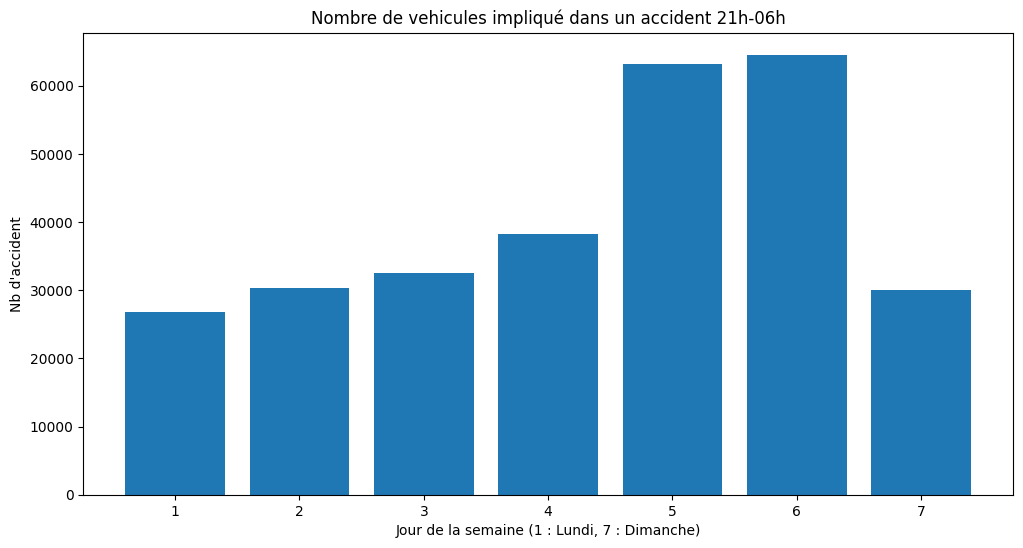

In [97]:
nb_vehicules = df_complet.groupby("night").size()
plt.figure(figsize=(12, 6))
plt.bar(nb_vehicules.index, nb_vehicules)
plt.title('Nombre de vehicules impliqué dans un accident 21h-06h')
plt.xlabel("Jour de la semaine (1 : Lundi, 7 : Dimanche)")
plt.ylabel("Nb d'accident")
plt.show()


## Nombre moyen de véhicules impliqué par accident

night
1    1.539632
2    1.554551
3    1.561219
4    1.542202
5    1.534138
6    1.511907
7    1.543524
dtype: float64


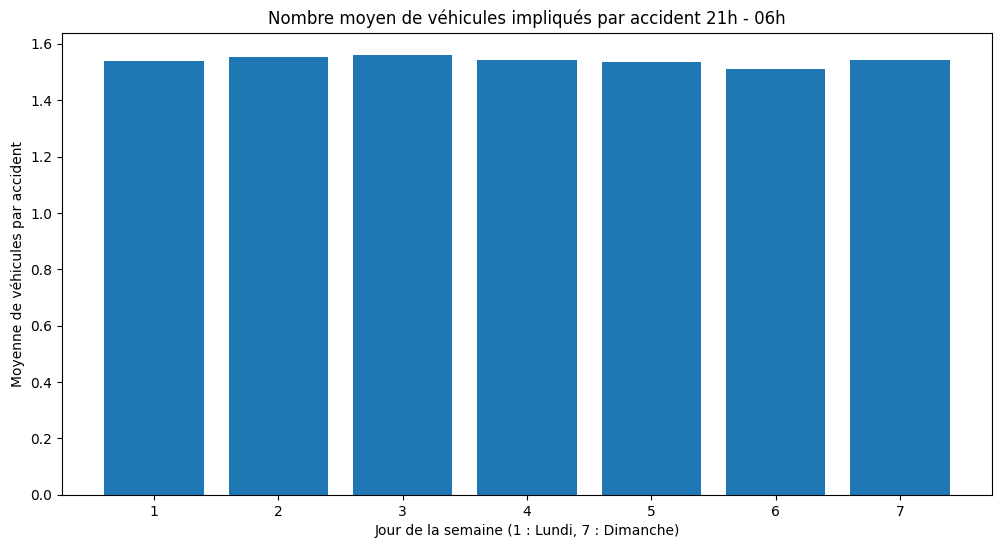

In [98]:
nb_vehicules = nb_vehicules.to_frame(name="nb_vehicules")
vehicules_par_accident = nb_vehicules["nb_vehicules"] / nb_accidents["nb_accidents"]
print(vehicules_par_accident)
plt.figure(figsize=(12, 6))
plt.bar(vehicules_par_accident.index, vehicules_par_accident)
plt.title("Nombre moyen de véhicules impliqués par accident 21h - 06h")
plt.xlabel("Jour de la semaine (1 : Lundi, 7 : Dimanche)")  
plt.ylabel("Moyenne de véhicules par accident")
plt.show()

In [99]:
df_complet = df_complet.merge(df_usagers, on="Num_Acc", how = "inner")

In [100]:
df_complet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701403 entries, 0 to 701402
Data columns (total 63 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Num_Acc        701403 non-null  int64  
 1   an             701403 non-null  int64  
 2   mois           701403 non-null  int64  
 3   jour           701403 non-null  int64  
 4   hrmn           701403 non-null  object 
 5   lum            701403 non-null  int64  
 6   agg            701403 non-null  int64  
 7   int            701403 non-null  int64  
 8   atm            701371 non-null  float64
 9   col            701365 non-null  float64
 10  com            701391 non-null  object 
 11  adr            608859 non-null  object 
 12  gps            272087 non-null  object 
 13  lat            432275 non-null  float64
 14  long           430847 non-null  float64
 15  dep            701403 non-null  object 
 16  date           701403 non-null  object 
 17  weekday        701403 non-nul

## Nombre de personne impliqué dans un accident 


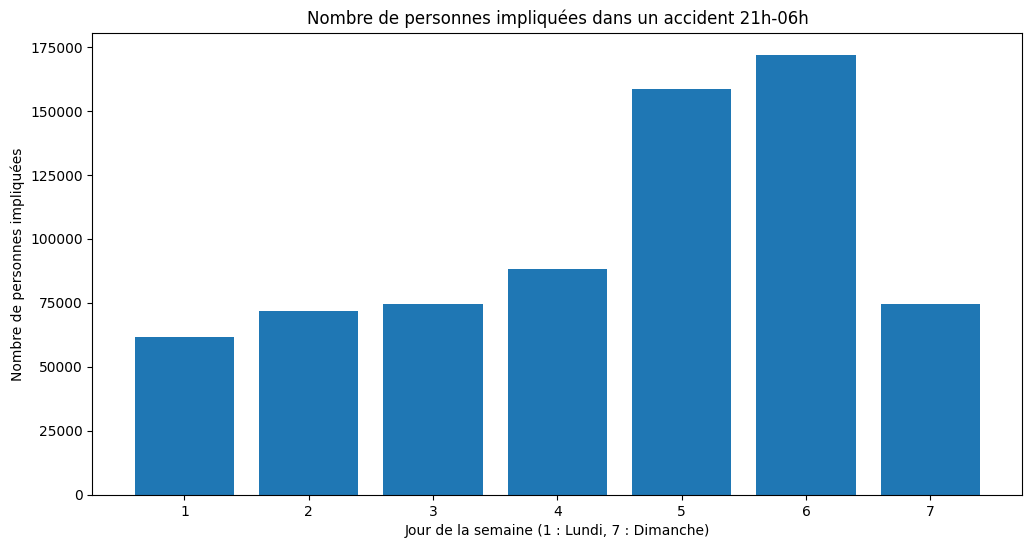

In [101]:
nb_personnes = df_complet.groupby("night").size().to_frame(name="nb_personnes")
plt.figure(figsize=(12, 6))
plt.bar(nb_personnes.index, nb_personnes["nb_personnes"])
plt.title("Nombre de personnes impliquées dans un accident 21h-06h")
plt.xlabel("Jour de la semaine (1 : Lundi, 7 : Dimanche)")
plt.ylabel("Nombre de personnes impliquées")
plt.show()

## Nombre moyen de personne impliqué par accident 

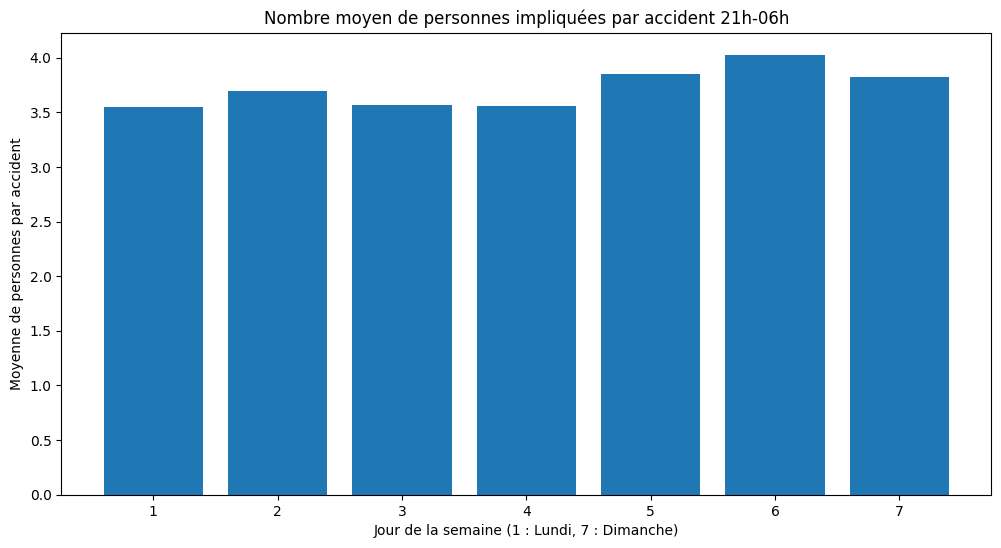

In [102]:
personnes_par_accident = nb_personnes["nb_personnes"] / nb_accidents["nb_accidents"]
plt.figure(figsize=(12, 6))
plt.bar(personnes_par_accident.index, personnes_par_accident)
plt.title("Nombre moyen de personnes impliquées par accident 21h-06h")
plt.xlabel("Jour de la semaine (1 : Lundi, 7 : Dimanche)")
plt.ylabel("Moyenne de personnes par accident")
plt.show()

## Save dataset

In [103]:
df_complet.to_csv(base / "Data_clean/full_night_21h_06h.csv", index=False)

## Calcul de l'age

In [ ]:
df_complet["age"] = df_complet["an"] - df_complet["an_nais"]


## Calcul du nb d'accident par âge 

In [114]:
for i in range(2005,2024):
    df_acc = df_complet[((df_complet["an"] == i) | (df_complet["an"] != 0)) & (df_complet["catu"] == 1)]
    age_accident = df_acc.groupby("age").size().sort_values(ascending=False).to_frame(name = "nb_accidents").reset_index()
    top_ages = age_accident
    
    globals()[f"df_acc_{i}"] = top_ages

## Répartition des accidents par âge de 2005 à 2023

    age  nb_accidents
16   18         10816
6    19         18651
2    20         21817
0    21         23109
1    22         22465
3    23         21599
4    24         20551
5    25         19224
7    26         18016
8    27         17032
9    28         15989
10   29         14830
11   30         13901
12   31         13013
13   32         12431
14   33         12060
15   34         11351
17   35         10600
18   36         10105
19   37          9457
20   38          9342
21   39          8959
22   40          8436
23   41          8318
24   42          7981


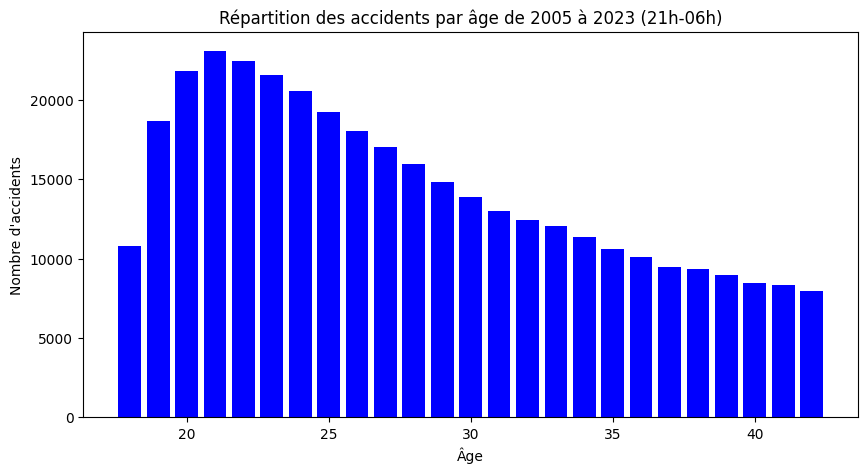

In [117]:
df_acc = df_complet[((df_complet["an_nais"] != 0) & (df_complet["an"] != 0)) & (df_complet["catu"] == 1)]
age_accident = df_acc.groupby("age").size().sort_values(ascending=False).to_frame(name = "nb_accidents").reset_index()
top_ages = age_accident.head(25)
top_ages = top_ages.sort_values(by="age")
print(top_ages)
plt.figure(figsize=(10, 5))
plt.bar(top_ages["age"], top_ages["nb_accidents"], color='blue')
plt.xlabel('Âge')   
plt.ylabel("Nombre d'accidents")
plt.title("Répartition des accidents par âge de 2005 à 2023 (21h-06h)")
plt.show()
    

## Binning des ages

In [121]:
# Analyser l'évolution des accidents par tranche d'âge pour toutes les années
bins = [18, 25, 35, 45, 55, 65, 100]  
all_years_data = []

for i in range(2005, 2024):
    # Utiliser le bon DataFrame pour chaque année
    df_year = globals()[f"df_acc_{i}"]
    
    # Créer les tranches d'âge
    df_year['tranche_age'] = pd.cut(df_year['age'], bins=bins)
    
    # Grouper par tranche d'âge
    accidents_par_tranche = df_year.groupby('tranche_age')['nb_accidents'].sum().to_frame(name="nb_accidents").reset_index()
    
    # Nettoyer les labels des tranches
    accidents_par_tranche["tranche_age"] = (accidents_par_tranche["tranche_age"]
                                           .astype(str)
                                           .str.replace("(", "", regex=False)
                                           .str.replace("]", "", regex=False)
                                           .str.replace(", ", "-", regex=False))
    
    # Ajouter l'année
    accidents_par_tranche['annee'] = i
    
    # Ajouter à la liste
    all_years_data.append(accidents_par_tranche)
    

# Combiner toutes les données
df_evolution = pd.concat(all_years_data, ignore_index=True)

df_evolution

C:\Users\jeanl\AppData\Local\Temp\ipykernel_10328\2504771454.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accidents_par_tranche = df_year.groupby('tranche_age')['nb_accidents'].sum().to_frame(name="nb_accidents").reset_index()
C:\Users\jeanl\AppData\Local\Temp\ipykernel_10328\2504771454.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accidents_par_tranche = df_year.groupby('tranche_age')['nb_accidents'].sum().to_frame(name="nb_accidents").reset_index()
C:\Users\jeanl\AppData\Local\Temp\ipykernel_10328\2504771454.py:13: FutureWarning: The default of observed=False is deprecated and will be changed

,tranche_age,nb_accidents,annee
0,18-25,147416,2005
1,25-35,139223,2005
2,35-45,85002,2005
3,45-55,57064,2005
4,55-65,26801,2005
...,...,...,...
109,25-35,139223,2023
110,35-45,85002,2023
111,45-55,57064,2023
112,55-65,26801,2023


## Répartition des accidents par tranche d'âge (21h-06h)

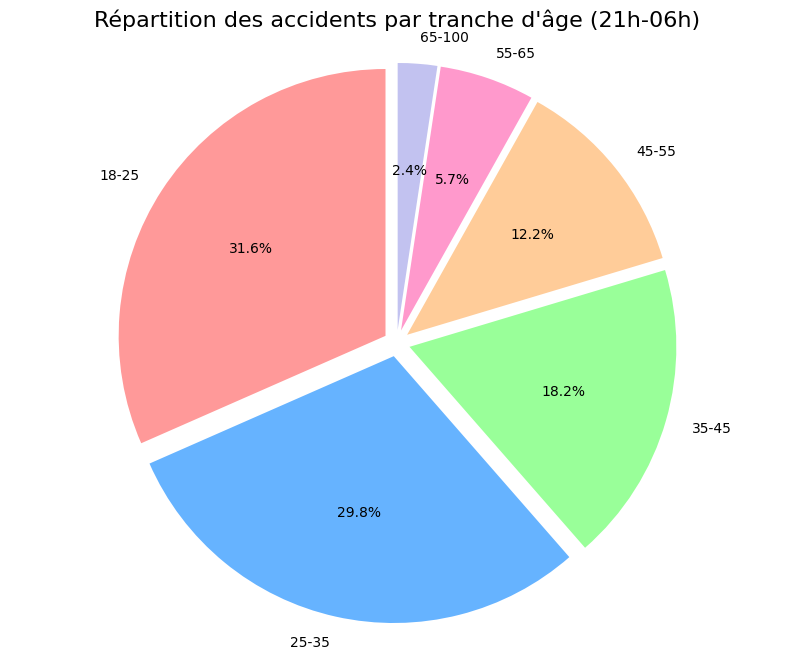

In [126]:
df_camembert = df_evolution.groupby("tranche_age").nb_accidents.sum().to_frame(name = "nb_accidents").reset_index()
# Camembert avec style
plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0']
plt.pie(df_camembert['nb_accidents'], 
        labels=df_camembert['tranche_age'], 
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05))  # Écarter les parts
plt.title('Répartition des accidents par tranche d\'âge (21h-06h)', fontsize=16)
plt.axis('equal')  # Pour avoir un cercle parfait
plt.show()

## Répartition des accidents par tranche d'âge UNIQUEMENT le samedi (21h-06h)

C:\Users\jeanl\AppData\Local\Temp\ipykernel_10328\886016529.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accidents_par_tranche = df_year.groupby('tranche_age')['nb_accidents'].sum().to_frame(name="nb_accidents").reset_index()
C:\Users\jeanl\AppData\Local\Temp\ipykernel_10328\886016529.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accidents_par_tranche = df_year.groupby('tranche_age')['nb_accidents'].sum().to_frame(name="nb_accidents").reset_index()
C:\Users\jeanl\AppData\Local\Temp\ipykernel_10328\886016529.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to

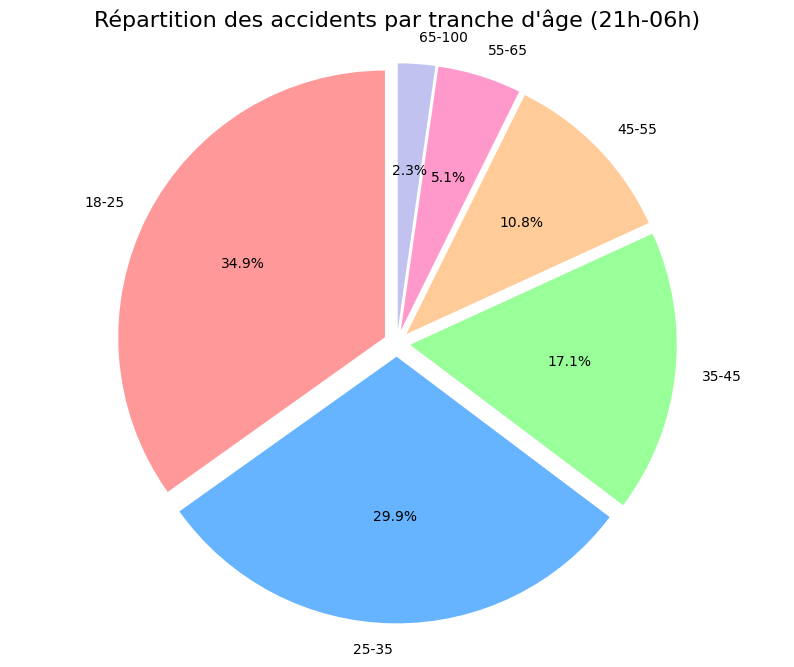

In [129]:
df_saturday = df_complet[df_complet["night"]==6]

for i in range(2005,2024):
    df_acc = df_saturday[((df_saturday["an"] == i) | (df_saturday["an"] != 0)) & (df_saturday["catu"] == 1)]
    age_accident = df_acc.groupby("age").size().sort_values(ascending=False).to_frame(name = "nb_accidents").reset_index()
    top_ages = age_accident
    
    globals()[f"df_acc_{i}"] = top_ages
    
# Analyser l'évolution des accidents par tranche d'âge pour toutes les années
bins = [18, 25, 35, 45, 55, 65, 100]  
all_years_data = []

for i in range(2005, 2024):
    # Utiliser le bon DataFrame pour chaque année
    df_year = globals()[f"df_acc_{i}"]
    
    # Créer les tranches d'âge
    df_year['tranche_age'] = pd.cut(df_year['age'], bins=bins)
    
    # Grouper par tranche d'âge
    accidents_par_tranche = df_year.groupby('tranche_age')['nb_accidents'].sum().to_frame(name="nb_accidents").reset_index()
    
    # Nettoyer les labels des tranches
    accidents_par_tranche["tranche_age"] = (accidents_par_tranche["tranche_age"]
                                           .astype(str)
                                           .str.replace("(", "", regex=False)
                                           .str.replace("]", "", regex=False)
                                           .str.replace(", ", "-", regex=False))
    
    # Ajouter l'année
    accidents_par_tranche['annee'] = i
    
    # Ajouter à la liste
    all_years_data.append(accidents_par_tranche)
    

# Combiner toutes les données
df_evolution = pd.concat(all_years_data, ignore_index=True)

df_camembert = df_evolution.groupby("tranche_age").nb_accidents.sum().to_frame(name = "nb_accidents").reset_index()
# Camembert avec style
plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0']
plt.pie(df_camembert['nb_accidents'], 
        labels=df_camembert['tranche_age'], 
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05))  # Écarter les parts
plt.title('Répartition des accidents par tranche d\'âge (21h-06h)', fontsize=16)
plt.axis('equal')  # Pour avoir un cercle parfait
plt.show()

## Évolution des accidents par tranche d'âge  - 2005-2023

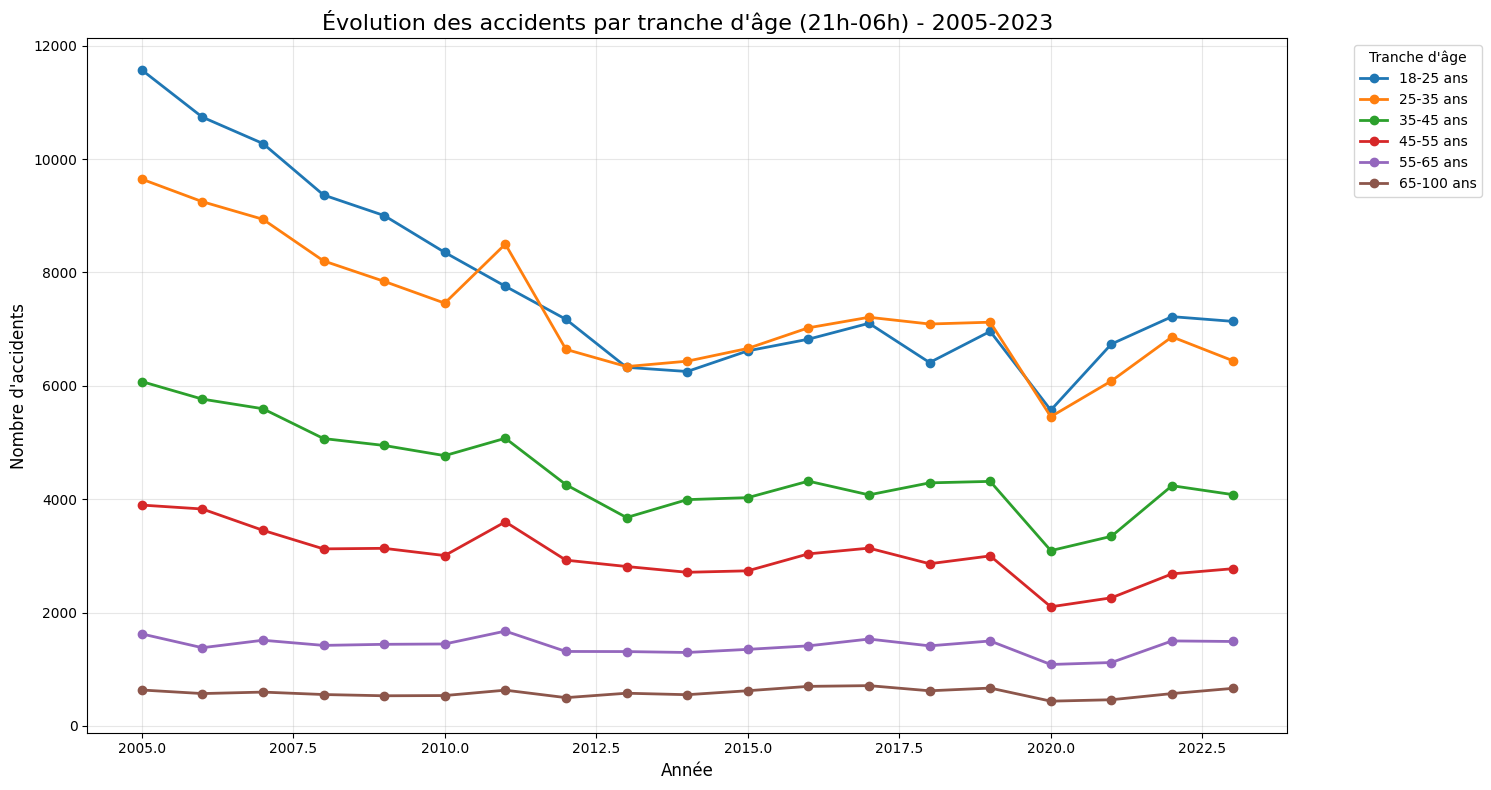


Tableau pivot - Accidents par année et tranche d'âge:
tranche_age  18-25  25-35  35-45  45-55  55-65  65-100
annee                                                 
2005         11575   9648   6076   3896   1623     633
2006         10742   9250   5766   3827   1379     570
2007         10276   8939   5596   3451   1511     596
2008          9368   8205   5070   3123   1420     553
2009          9005   7844   4948   3133   1439     531
2010          8355   7459   4768   3005   1445     535
2011          7757   8501   5075   3600   1672     630
2012          7174   6643   4256   2924   1313     498
2013          6327   6340   3676   2812   1311     576
2014          6253   6435   3992   2710   1295     550
2015          6617   6660   4027   2736   1350     620
2016          6823   7024   4318   3035   1412     697
2017          7104   7210   4076   3136   1532     710
2018          6411   7091   4288   2861   1412     619
2019          6961   7123   4314   2999   1498     667
2020      

In [120]:
# Visualiser l'évolution des accidents par tranche d'âge
plt.figure(figsize=(15, 8))

# Créer une courbe pour chaque tranche d'âge
for tranche in df_evolution['tranche_age'].unique():
    if pd.notna(tranche):  # Ignorer les valeurs NaN
        data_tranche = df_evolution[df_evolution['tranche_age'] == tranche]
        plt.plot(data_tranche['annee'], data_tranche['nb_accidents'], 
                marker='o', linewidth=2, label=f'{tranche} ans')

plt.title('Évolution des accidents par tranche d\'âge (21h-06h) - 2005-2023', fontsize=16)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Nombre d\'accidents', fontsize=12)
plt.legend(title='Tranche d\'âge', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Créer un tableau pivot pour une vue d'ensemble
pivot_table = df_evolution.pivot(index='annee', columns='tranche_age', values='nb_accidents')
print("\nTableau pivot - Accidents par année et tranche d'âge:")
print(pivot_table)